## Data Exploration for Albuquerque Crime Data

In [1]:
import os
import time
from tqdm import tqdm

import pyproj
import shapely
import abq_utils
import numpy as np
import pandas as pd

import gmaps
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.style.use("ggplot")

### Authenticate Google Maps

In [3]:
# Set up API Authentication.
key_path = "/Users/administrator/Documents/Projects/abq_crime/api_key.txt"
with open(key_path) as f:
    api_key = f.readline()
    f.close()

gmaps.configure(api_key=api_key)

### Load the Data

In [4]:
# Load the DataFrame.
dataframe_path = "/Users/administrator/Documents/Projects/abq_crime/data/processed_dataframe.pkl"
dataframe = pd.read_pickle(dataframe_path)

In [5]:
# Load the Zip Code data.
shapefile_path = "/Users/administrator/Documents/Projects/abq_crime/shapefiles/zipcodes/zipcodes.shp"
zipcodes_dataframe = gpd.read_file(shapefile_path)

# Keep only the relevant columns.
keep_columns = ["ZIPCODE", "geometry"]
zipcodes_dataframe = zipcodes_dataframe[keep_columns]

In [6]:
# Get the indices of the zip codes whose geometry is a multipolygon.
mpolygon_indices = [type(item) == shapely.geometry.multipolygon.MultiPolygon for item in zipcodes_dataframe["geometry"]]
mpolygon_indices = [idx for idx, item in enumerate(mpolygon_indices) if item == True]

In [7]:
# For those above indices, create new entries in the DataFrame.
new_entries = list()
start_time = time.time()
for index in mpolygon_indices:
    zipcode = zipcodes_dataframe.iloc[index]["ZIPCODE"]
    for poly in zipcodes_dataframe.iloc[index]["geometry"]:
        new_entries.append((zipcode, poly))
end_time = time.time()

print("Entire operation took {} seconds.".format(end_time - start_time))

Entire operation took 0.001561880111694336 seconds.


In [8]:
# Add those entries to the DataFrame.
for entry in new_entries:
    zipcodes_dataframe.loc[len(zipcodes_dataframe)] = entry

# Delete the original entries.
zipcodes_dataframe.drop(mpolygon_indices, axis=0, inplace=True)
zipcodes_dataframe.reset_index(drop=True, inplace=True)

In [9]:
# Create a list of Polygons with converted coordinates.
zipcodes_polygons = list()
for idx in tqdm(range(len(zipcodes_dataframe["geometry"]))):
    zipcodes_polygons.append(abq_utils.batch_convert_coordinates(zipcodes_dataframe["geometry"][idx].exterior.coords[:]))

100%|██████████| 28/28 [00:04<00:00,  6.80it/s]


### Basic Crime Analysis

* We examine the distribution of crime based on the day of the week.
* We examine the distribution of crime based on the crime category (a.k.a. crime description)

#### Distribution by Day of the Week

Text(0.5, 1.0, 'Distribution of Crimes by the Day of the Week')

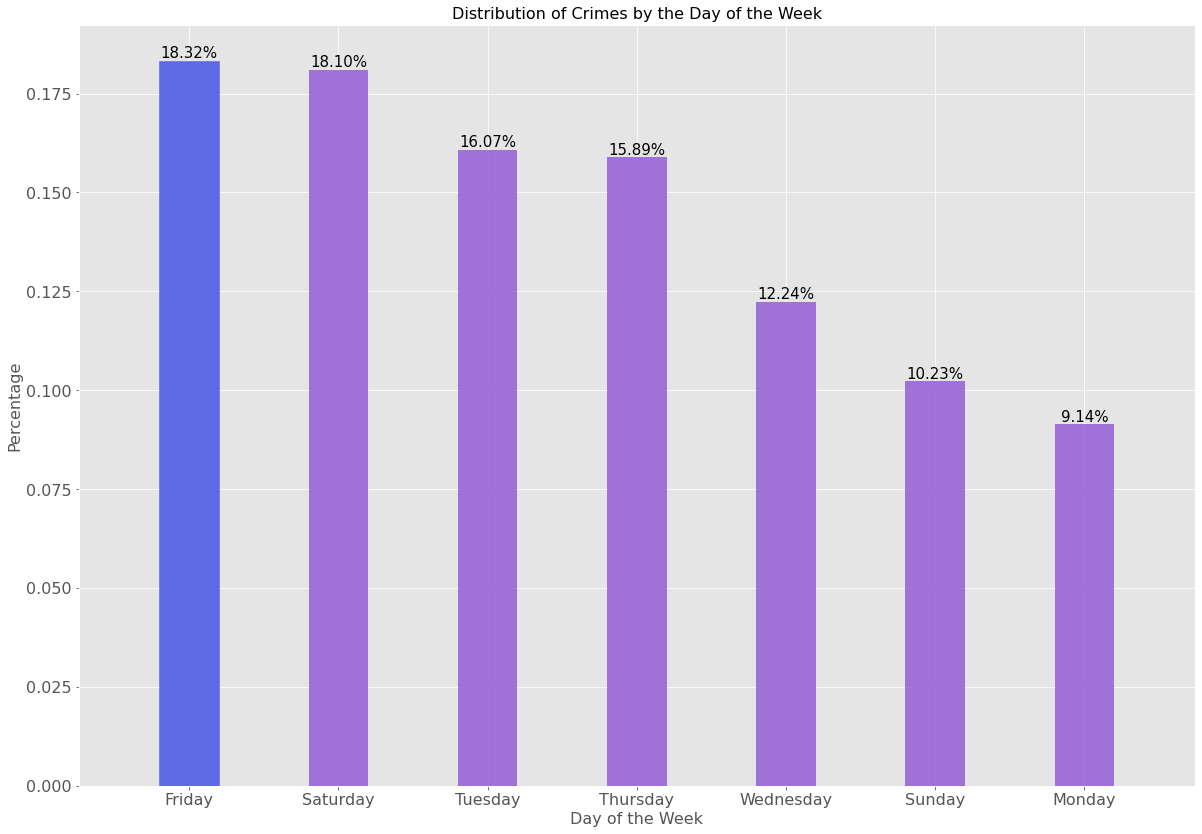

In [10]:
# Obtain the distribution of crimes, based on the day of the week.
distribution_dow = dataframe["Day of Week"].value_counts()
total_crimes = distribution_dow.sum()

distribution_dow = pd.DataFrame(distribution_dow).reset_index(inplace=False)
distribution_dow.columns = ["Day of Week", "Count"]
distribution_dow["Count"] = distribution_dow["Count"].apply(lambda x: x / total_crimes)

# Plot the distribution of crimes based on the day of the week.
plt.rcParams["figure.figsize"] = (20, 14)
barplot = plt.bar(distribution_dow["Day of Week"], distribution_dow["Count"], color="#945dd4", alpha=0.85)
abq_utils.change_bar_width(barplot, 0.4)
barplot[0].set_color("#4653e4")

# Plot the percentages on top of the bars.
abq_utils.plot_percentages_bar(barplot)

# Fix the visualization.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Day of the Week", fontsize=16)
plt.ylabel("Percentage", rotation=90, fontsize=16)
plt.title("Distribution of Crimes by the Day of the Week", fontsize=16)

#### Distribution by Crime Type

* We first show the distribution taking into account ALL crime types.
* We then show the distribution taking into account only the top ten crime types.
* Next, we show the distribution taking into account only the bottom ten crime types.

Text(0, 0.5, 'Percentage')

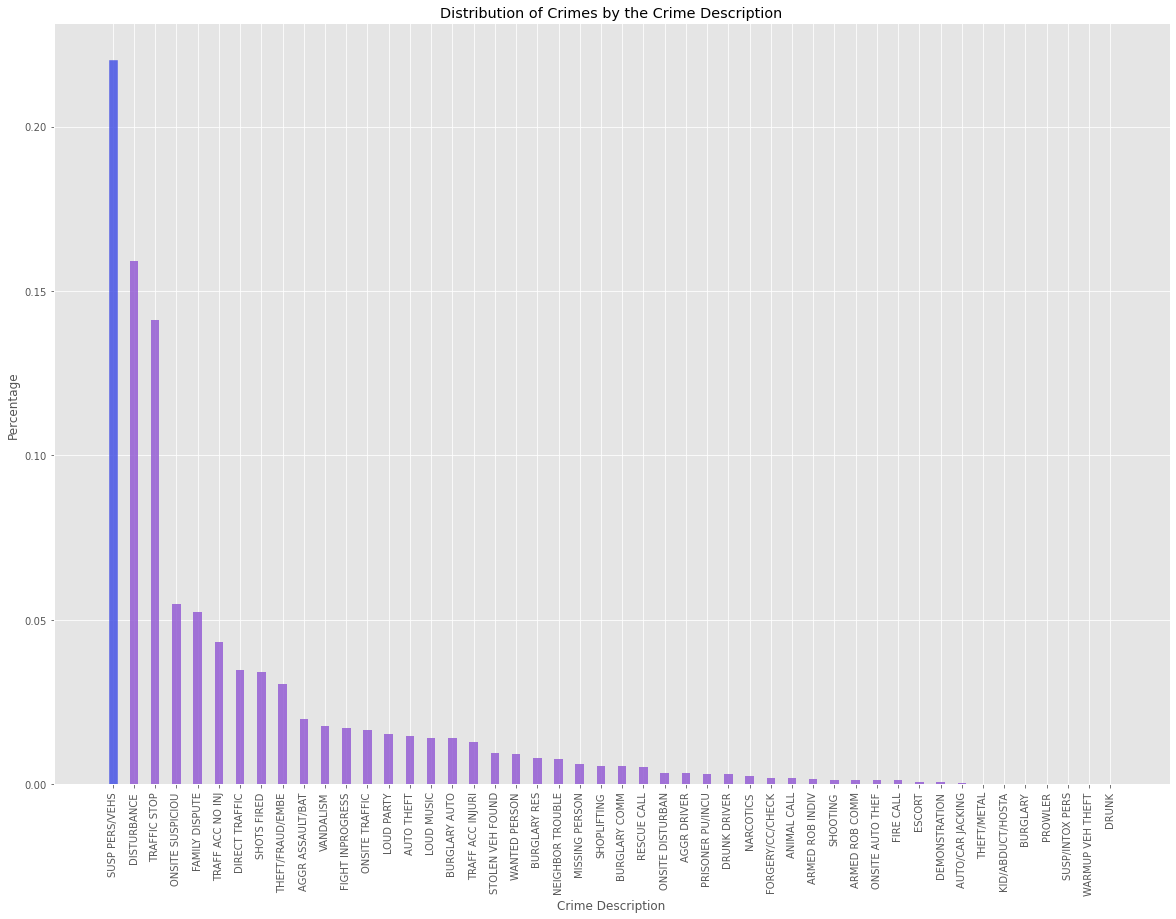

In [11]:
distribution_crime_type = dataframe["Description"].value_counts()
total_crimes = distribution_crime_type.sum()

distribution_crime_type = pd.DataFrame(distribution_crime_type).reset_index()
distribution_crime_type.columns = ["Description", "Count"]
distribution_crime_type["Count"] = distribution_crime_type["Count"].apply(lambda x: x / total_crimes)

# Plot the distribution of crimes based on the type of crime.
plt.rcParams["figure.figsize"]=  (20, 14)
barplot = plt.bar(distribution_crime_type["Description"], distribution_crime_type["Count"], color="#945dd4", alpha=0.85)
abq_utils.change_bar_width(barplot, 0.4)
barplot[0].set_color("#4653e4")

# Fix up the visualization.
_ = plt.xticks(rotation=90)
plt.title("Distribution of Crimes by the Crime Description")
plt.xlabel("Crime Description")
plt.ylabel("Percentage")

That's not a really helpful graph because some crimes don't occur as often. Let's see only the top ten crimes instead.

Text(0, 0.5, 'Percentage')

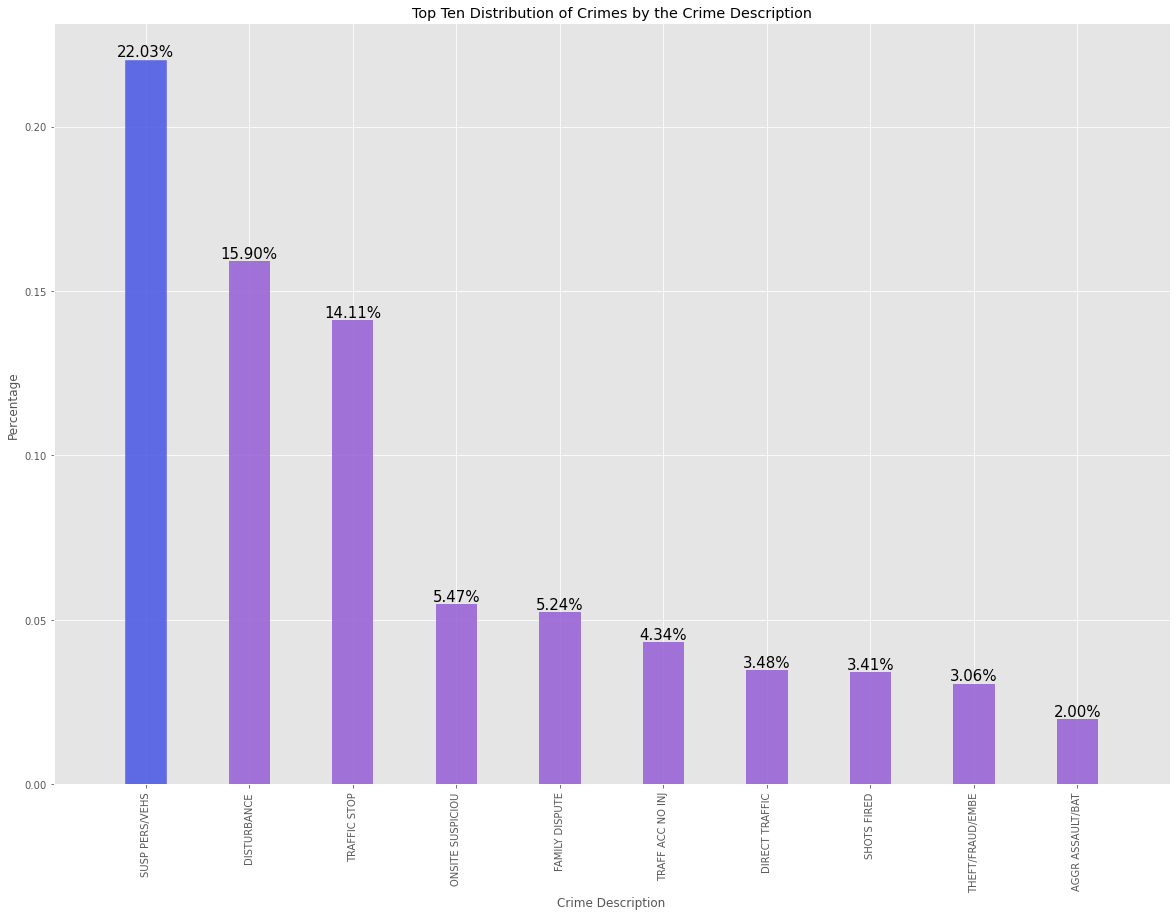

In [12]:
top_ten_crimes = distribution_crime_type[0:10]

barplot = plt.bar(top_ten_crimes["Description"], top_ten_crimes["Count"], color="#945dd4", alpha=0.85)
abq_utils.change_bar_width(barplot, 0.4)
barplot[0].set_color("#4653e4")

# Plot the percentages.
abq_utils.plot_percentages_bar(barplot)

# Fix the visualization.
_ = plt.xticks(rotation=90)
plt.title("Top Ten Distribution of Crimes by the Crime Description")
plt.xlabel("Crime Description")
plt.ylabel("Percentage")

Text(0, 0.5, 'Percentage')

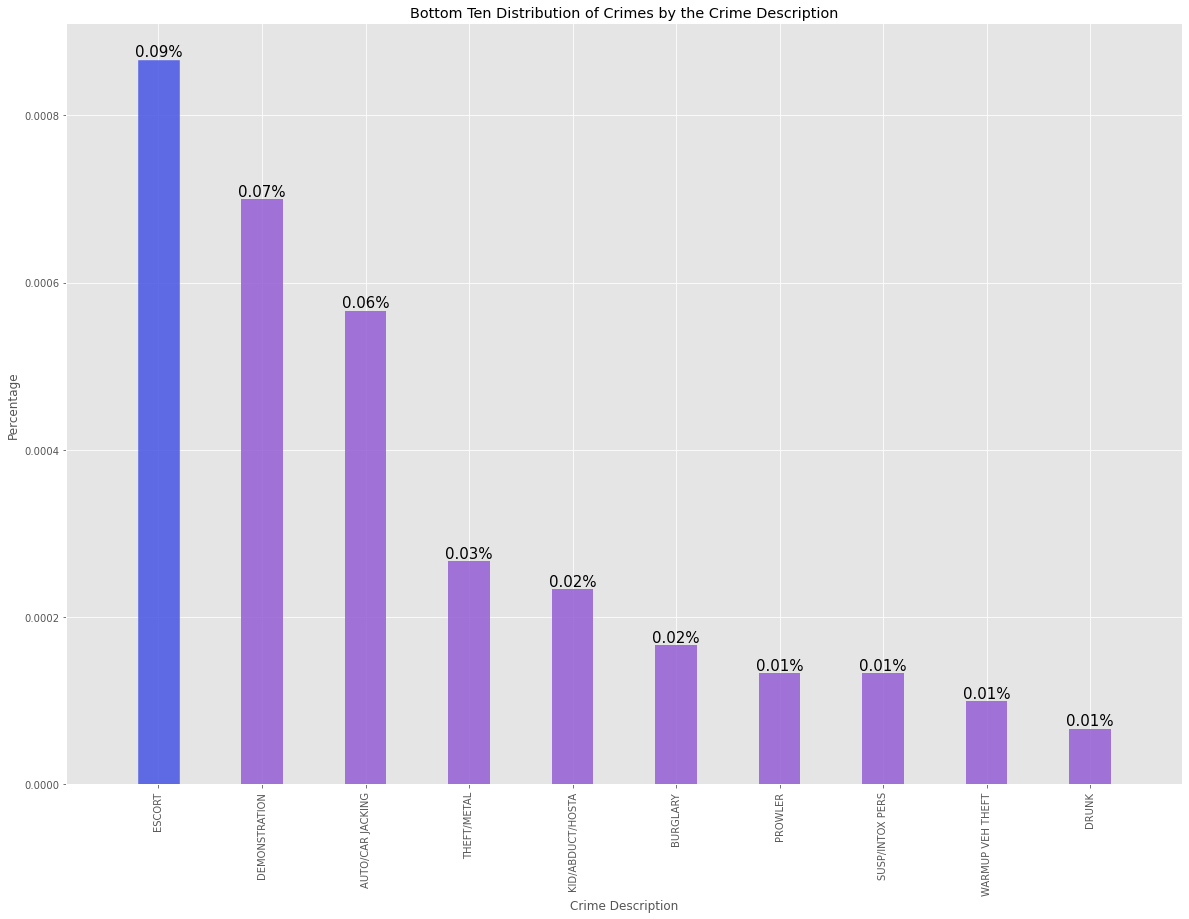

In [13]:
bottom_ten_crimes = distribution_crime_type[-10:]

barplot = plt.bar(bottom_ten_crimes["Description"], bottom_ten_crimes["Count"], color="#945dd4", alpha=0.85)
abq_utils.change_bar_width(barplot, 0.4)
barplot[0].set_color("#4653e4")

# Plot the percentages 
abq_utils.plot_percentages_bar(barplot)

# Fix the visualization.
plt.xticks(rotation=90)
plt.title("Bottom Ten Distribution of Crimes by the Crime Description")
plt.xlabel("Crime Description")
plt.ylabel("Percentage")

In [14]:
# Insert some sort of analysis here.

### Crime Heatmap

* We create a heatmap to represent spots where crime occurs.

In [15]:
# Extract the locations from the DataFrame.
locatable_incidents = dataframe.dropna()
incident_locations = locatable_incidents[["Latitude", "Longitude"]]

In [16]:
# Set up the map and plot it.
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(incident_locations)
fig.add_layer(heatmap_layer)

# Calibrate the map.
heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 10

fig

Figure(layout=FigureLayout(height='420px'))

Insert summary analysis here.

### Zip Code Analysis

* We analyze the number of crimes by Zip Code.

#### Computing the Weights

In [17]:
# Extract the latitude and longitude data, and remove nan entries.
coords_dataframe = dataframe[["Latitude", "Longitude"]]
coords_dataframe.dropna(inplace=True)

# Create a list of Polygons to check.
zipcodes_polygons_list = [shapely.geometry.Polygon(poly) for poly in zipcodes_polygons]

In [18]:
# Find the zip code that each of the points belong to..
weights = np.zeros(len(zipcodes_polygons))
start_time = time.time()
for row in tqdm(coords_dataframe.itertuples()):
    coords = (row[1], row[2])
    zipcode_index = abq_utils.test_membership(coords, zipcodes_polygons_list)
    if zipcode_index != -1:
        weights[zipcode_index] += 1
weights = weights / weights.sum()
end_time = time.time()

28876it [00:10, 2879.07it/s]


In [19]:
# Plot the Polygons with their weights.
drawing_list = list()
for idx, polygon_coords in enumerate(tqdm(zipcodes_polygons)):
    drawing_list.append(gmaps.Polygon(polygon_coords, stroke_color="black", stroke_opacity=0.2, fill_color=(255, 0, 0), fill_opacity = 4 * weights[idx]))

100%|██████████| 28/28 [00:00<00:00, 90.48it/s] 


In [20]:
# Plot the Polygons using Google Maps API.
fig = gmaps.figure(center=(35.08541434188005, -106.65083179442777), zoom_level=12)
drawing = gmaps.drawing_layer(features=drawing_list, show_controls=False,)
fig.add_layer(drawing)
fig

Figure(layout=FigureLayout(height='420px'))

Let's repeat the analysis, this time taking into account areas that have no weight (i.e. crime data in that zipcode is not available)

In [21]:
# Find the zipcode indices that have no crime data.
ignore_indices = [idx for idx, item in enumerate(weights) if item == 0]

# Remove zipcodes at indices 1, 2, 5, 9, 16.
modified_zipcodes_polygons = [entry for idx, entry in enumerate(zipcodes_polygons) if idx not in ignore_indices]
modified_polygon_list = [shapely.geometry.Polygon(poly) for poly in modified_zipcodes_polygons]

In [56]:
# Compute the new weights.
modified_weights = np.zeros(len(modified_polygon_list))
start_time = time.time()
for row in tqdm(coords_dataframe.itertuples()):
    coords = (row[1], row[2])
    zipcode_index = abq_utils.test_membership(coords, modified_polygon_list)
    if zipcode_index != -1:
        modified_weights[zipcode_index] += 1
modified_weights = modified_weights / modified_weights.sum()
end_time = time.time()

print("Entire operation took {} seconds.".format(end_time - start_time))

28876it [00:08, 3502.51it/s]Entire operation took 8.247201204299927 seconds.



In [63]:
# Plot the Polygons with their weights.
drawing_list = list()
for idx, polygon_coords in enumerate(tqdm(modified_zipcodes_polygons)):
    drawing_list.append(gmaps.Polygon(polygon_coords, stroke_color="black", stroke_opacity=0.2, fill_color=(255, 0, 0,), fill_opacity=4 * modified_weights[idx]))

100%|██████████| 23/23 [00:00<00:00, 54.35it/s]


In [64]:
# Plot the Polygons using Google Maps API.
fig = gmaps.figure(center=(35.08541434188005, -106.65083179442777), zoom_level=12)
drawing = gmaps.drawing_layer(features=drawing_list, show_controls=False,)
fig.add_layer(drawing)
fig

Figure(layout=FigureLayout(height='420px'))